In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime

In [347]:
class CDF():
    def __init__(self,path,data='hgt'):
        self.path = path
        self.retrieve_data(data)    
        self.localize()
    
    
    def __str__(self):
        return f"{self.year}\nTimes: {len(self.times)}\nLevels: {self.hgts.shape[1]}"
    
    
    def retrieve_data(self,name='hgt'):
        self.year = int(self.path.split('.')[-2])
        fh = Dataset(self.path, mode='r')
        self.lons = fh.variables['lon'][:].data
        self.lats = fh.variables['lat'][:].data
        times = fh.variables['time'][:].data
        self.times = times - times[0]
        self.data = fh.variables[name][:].data
    
    
    def localize(self,lat0=20,lat1=70,lon0=220,lon1=340): # Default US localization
        lat_mask = ((self.lats>=lat0) & (self.lats<=lat1)) # Originally 20 - 60
        self.loc_lats = self.lats[lat_mask]

        lon_mask = ((self.lons>=lon0) & (self.lons<=lon1)) # Originally 240 - 340
        self.loc_lons = self.lons[lon_mask]

        start_lat = np.argwhere(lat_mask).min()
        end_lat = np.argwhere(lat_mask).max()

        start_lon = np.argwhere(lon_mask).min()
        end_lon = np.argwhere(lon_mask).max()
        
        self.loc_data = self.data[:,:,start_lat:end_lat+1,start_lon:end_lon+1]
        
    
    def plot(self, day=1, level=1, loc=False, contours=None, figsize=(6.4,4.8),cmap='RdBu_r', norm=True, date=None):
        
        if date: # Date input as (Month,Day) numerical tuple
            day = datetime.datetime(self.year,*date).timetuple().tm_yday # for date to day
        
        plt.figure(figsize=figsize)
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        if loc:
            data = self.loc_data[day-1,level-1,:,:]
            lons = self.loc_lons
            lats = self.loc_lats
        else:
            data = self.data[day-1,level-1,:,:]
            lons = self.lons
            lats = self.lats
        if norm:
            data = (data-data.min())/(data.max()-data.min())
        if contours:
            cs = plt.contour(lons,lats,data, levels=contours, transform =ccrs.PlateCarree())
            if not norm: ax.clabel(cs,inline=1,fmt='%1.0f');
            else: ax.clabel(cs,inline=1)
            
            
        date = (datetime.datetime(self.year, 1, 1) + datetime.timedelta(day - 1)).strftime(r'%b %d %Y')
        title_str = str(date)+' : Level '+str(level)
        title_str = f"{date} ({day}) : Level {level}"
        ax.set_title(title_str)
        
        plt.contourf(lons, lats, hgts, 200, transform=ccrs.PlateCarree(),cmap=cmap)
        ax.coastlines()
        plt.colorbar(orientation='horizontal',pad=0.03)
        plt.show()

In [346]:
cdf = CDF("E:\hgt.2012.nc")

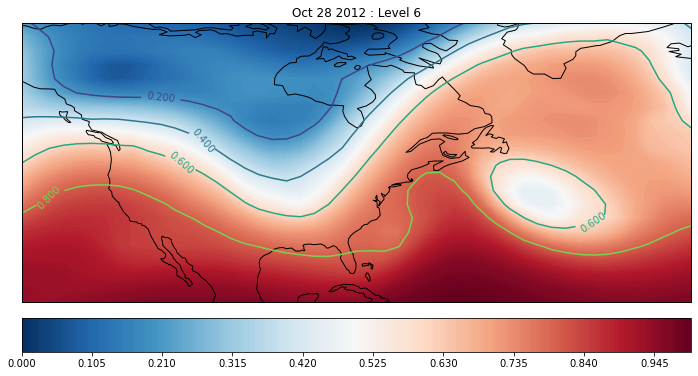

In [160]:
cdf.plot(date=(10,28), level=6, loc=True, figsize=(12,10), norm=True, contours=5)

In [162]:
k2 = CDF("E:\hgt.2012.nc")

In [273]:
lons = k2.loc_lons
lats = k2.loc_lats
hgts = k2.loc_hgts
hgts.shape

(366, 12, 25, 48)

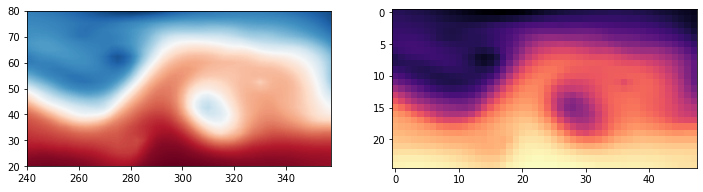

In [288]:
date = (10,27)
level = 6
day = datetime.datetime(2012,*date).timetuple().tm_yday
# plt.imshow(hgts[day-1,level-1])
cur_hgts = hgts[day-1,level-1]
cur_hgts = (cur_hgts - cur_hgts.min()) / (cur_hgts.max()-cur_hgts.min())
# Reverse hgts because:
    # Top of imshow is top of array
    # Bottom of plot is first element of array
fig = plt.figure(figsize=(12,5))
axes = fig.subplots(1,2)
axes[0].contourf(lons,lats[::-1],cur_hgts[::-1],levels=900,cmap='RdBu_r')
axes[0].set_aspect('equal')
axes[1].imshow(cur_hgts,cmap='magma')
plt.show()

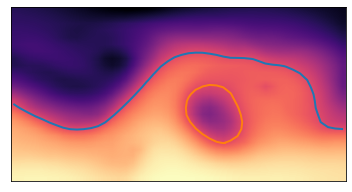

In [290]:
from skimage import measure
from skimage import feature
contours = measure.find_contours(cur_hgts, 0.6)
fig, ax = plt.subplots()
ax.imshow(cur_hgts,interpolation='bilinear', cmap='magma')

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

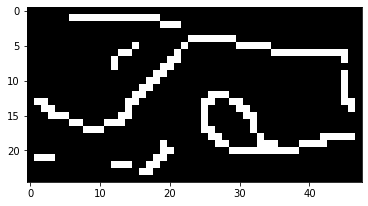

In [298]:
edges = feature.canny(cur_hgts,sigma=1).astype(np.uint8)
plt.imshow(edges,cmap='gist_gray')
plt.show()

In [300]:
from scipy.ndimage import convolve

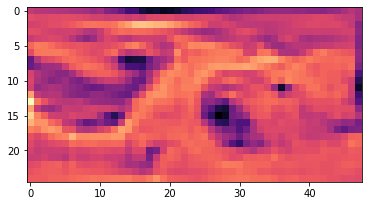

In [315]:
kernel = np.array([[-1,0,-1],
                   [0,4,0],
                   [-1,0,-1]])
conv = convolve(cur_hgts, kernel)
plt.imshow(conv, cmap='magma')

1. Where is the tip of the trough?
    - Lattitude / Longitude
## Look at Level 6

Upper air Trough over central US leading to SW to NE component 

In [339]:
uwinds = CDF(r"E:\uwnd.2012.nc", data='uwnd')
vwinds = CDF(r"E:\vwnd.2012.nc", data='vwnd')

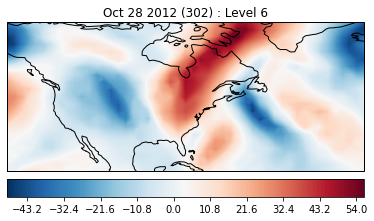

In [340]:
vwinds.plot(date=(10,28), level=6, loc=True, norm=False)

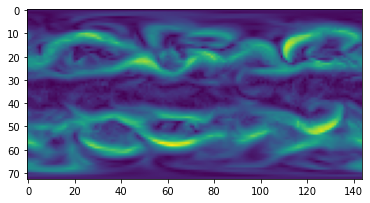

In [348]:
wind_spd = np.sqrt(np.square(vwinds.hgts[302,6]) + np.square(uwinds.hgts[302,6]))
plt.imshow(wind_spd)